In [2]:
from sage.all import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pretty_print_default(True)
%display latex

In [3]:
Λ, τ, σ, μ, θ = var('Lambda','tau','sigma', 'mu', 'theta')
σ2 = σ^2

In [4]:
def get_tau_vars(d):
    diag = [var(f'tau{i}{i}') for i in range(1, d+1)]
    off  = [var(f'tau{i}{j}') for i in range(1, d+1) for j in range(i+1, d+1)]
    return diag + off

def precision_matrix(d):
    if d==2:
        C = Matrix([[3/8,1/8,0],
                    [1/8,3/8,0],
                    [0,  0,  1/8]])
    elif d==3:
        C = Matrix([[1/5, 1/15,1/15, 0,    0,    0],
                    [1/15,1/5, 1/15, 0,    0,    0],
                    [1/15,1/15,1/5,  0,    0,    0],
                    [0,   0,   0,    1/15, 0,    0],
                    [0,   0,   0,    0,    1/15, 0],
                    [0,   0,   0,    0,    0,    1/15]] )
    else:
        raise ValueError("Only d=2 or 3 supported")
    return C.inverse()

In [5]:
def delta_contrast_Zel(d):
    """
    The Zeldovich toy-model Δ(τ): one convenient default delta_func.
    """
    taus = get_tau_vars(d)
    T = Matrix(SR, d); k = 0
    for i in range(d):
        T[i,i] = taus[k]; k += 1
    for i in range(d):
        for j in range(i+1,d):
            T[i,j] = T[j,i] = taus[k]; k += 1
    return 1/abs(((identity_matrix(SR,d) - T).det())) - 1

# Ellipsoidal collapse in terms of τ‐variables (Eq. 5.3):
def delta_contrast_ellipsoidal(d, nu_param = var('nu')):
    """
    Ellipsoidal‐collapse density contrast Δ(τ) ≡ ρ(τ) − 1
      - d         : dimension (e.g. 3)
      - nu_param  : ellipticity exponent ν
    """

    taus = get_tau_vars(d)
    T = Matrix(SR, d); k = 0
    for i in range(d):
        T[i,i] = taus[k]; k += 1
    for i in range(d):
        for j in range(i+1,d):
            T[i,j] = T[j,i] = taus[k]; k += 1
    
    # 2) linear contrast δ = sum_i tau_ii
    delta_lin = T.trace()
    
    # 3) build the total density ρ(τ) and subtract 1 to get Δ
    rho = (1 - delta_lin/d)^d / (1 - delta_lin/nu_param)^nu_param / ((identity_matrix(SR,d) - T).det())

    return rho - 1

def theta_Zel(d):
    """
    Zeldovich velocity-divergence map:
      theta = - Tr[(I - T)^(-1) T]
    (f=1 assumed; multiply by f(eta) if needed).
    """
    taus = get_tau_vars(d)
    T = Matrix(SR, d)
    k = 0
    for i in range(d):
        T[i,i] = taus[k]; k += 1
    for i in range(d):
        for j in range(i+1, d):
            T[i,j] = T[j,i] = taus[k]; k += 1

    IminT_inv = (identity_matrix(SR, d) - T).inverse()
    return -(IminT_inv * T).trace().factor()

In [6]:
def theta_Zel_spherical(d):
    theta = theta_Zel(d)
    taus = get_tau_vars(d)
    subs = {v: τ for v in taus[:d]}
    subs.update({v: 0 for v in taus[d:]})
    return theta.subs(subs).factor()

In [7]:
theta_Zel_spherical(3)

3*tau/(tau - 1)

In [8]:
# 2) Joint action in the full tau-space
def action_joint(d, Λ, μ, nu=None):
    if nu is None:
        nu = d
    taus = get_tau_vars(d)
    Δ    = delta_contrast_ellipsoidal(d, nu)
    θ    = theta_Zel(d)
    P    = precision_matrix(d)
    quad = sum(taus[i] * sum(P[i,j]*taus[j] for j in range(len(taus)))
               for i in range(len(taus)))
    return Λ*Δ + θ*μ - (1/2)*quad

# 3) Spherical reduction: τ_{ij} = τ * δ_{ij} -> single var
def action_spherical_joint(d, Λ, μ, nu=None):
    # substitute τ_ii=τ, τ_ij≠i=0 into joint action
    S_full = action_joint(d, Λ, μ, nu)
    taus = get_tau_vars(d)
    subs = {v: τ for v in taus[:d]}
    subs.update({v: 0 for v in taus[d:]})
    return S_full.subs(subs)


In [9]:
def hessian_joint_full(d, Λ, μ, nu=None):
    if nu is None:
        nu = d
    taus = get_tau_vars(d)
    S    = action_joint(d, Λ, μ, nu)
    n    = len(taus)
    H    = Matrix(SR, n, n)
    for i in range(n):
        for j in range(n):
            H[i,j] = diff(S, taus[i], taus[j])
    return H
def hessian_spherical(d, Λ, μ, nu=None):
    if nu is None:
        nu = d
    Hf   = hessian_joint_full(d, Λ, μ, nu)
    taus = get_tau_vars(d)
    subs = {v:τ for v in taus[:d]}
    subs.update({v:0 for v in taus[d:]})
    return Hf.subs(subs).apply_map(lambda x: x.factor())


In [10]:
def saddle_equation(d, nu=None):
    # 1) Build the 1D action under spherical ansatz
    S_tau = action_spherical_joint(d, Λ, μ, nu)
    # 2) Compute derivative w.r.t. tau
    eq = diff(S_tau, τ).numerator().factor()
    # only normalize by the Λ-coefficient when it’s nonzero
    #coeff_L = eq.coefficient(Λ)
    #if coeff_L != 0:
        #eq /= coeff_L
    return eq

In [11]:
show("Saddle eq (d=2):", saddle_equation(2).factor() == 0)
show("Saddle eq (d=3):", saddle_equation(3).factor() == 0)

'Saddle eq (d=2):' -4*tau^4 + 12*tau^3 - 2*mu*tau - 12*tau^2 - 2*Lambda + 2*mu + 4*tau == 0

'Saddle eq (d=3):' -9*tau^5 + 36*tau^4 - 3*mu*tau^2 - 54*tau^3 + 6*mu*tau + 36*tau^2 + 3*Lambda - 3*mu - 9*tau == 0

In [12]:
def tau_series(d, total_order=4, nu=None):
    """
    Return τ(μ,Λ) to the requested total order
    using Hensel/Newton lifting inside a power-series ring.
    """    
    if nu is None:
        nu = d

    # total-degree default_prec must exceed the order we want
    R.<mu, Lambda> = PowerSeriesRing(QQ, default_prec=total_order+2)
    PR.<tau>       = PolynomialRing(R)
    # build polynomial version of the saddle equation
    P_poly   = PR(saddle_equation(d, nu=nu).expand())
    dP_poly  = P_poly.derivative()

    # initial guess: constant term killing P at O(mu, Lambda)
    root = PR((Lambda - mu)/d)

    # Newton–Hensel lift in the polynomial ring over R
    for k in range(1, total_order+1):
        valP  = P_poly(root)
        valdP = dP_poly(root)
        # Convert to power series and truncate before division
        valP_trunc = R(valP).truncate(k+1)
        valdP_trunc = R(valdP).truncate(k+1)
        correction = valP_trunc / valdP_trunc
        root = root - PR(correction)
        root = root.truncate(k+1)

    return R(root).truncate(total_order+1).add_bigoh(total_order+1)

# examples for both dimensions
show("τ* (d=2):", tau_series(2))
show("τ* (d=3):", tau_series(3))


'τ* (d=2):' -1/2*mu + 1/2*Lambda + 1/2*mu^2 - 5/4*mu*Lambda + 3/4*Lambda^2 - 7/8*mu^3 + 7/2*mu^2*Lambda - 9/2*mu*Lambda^2 + 15/8*Lambda^3 + 15/8*mu^4 - 165/16*mu^3*Lambda + 165/8*mu^2*Lambda^2 - 143/8*mu*Lambda^3 + 91/16*Lambda^4 + O(mu, Lambda)^5

'τ* (d=3):' -1/3*mu + 1/3*Lambda + 2/9*mu^2 - 2/3*mu*Lambda + 4/9*Lambda^2 - 7/27*mu^3 + 4/3*mu^2*Lambda - 55/27*mu*Lambda^2 + 26/27*Lambda^3 + 10/27*mu^4 - 220/81*mu^3*Lambda + 182/27*mu^2*Lambda^2 - 560/81*mu*Lambda^3 + 68/27*Lambda^4 + O(mu, Lambda)^5

In [11]:
from sage.all import QQ, PowerSeriesRing, var
from sage.misc.sage_eval import sage_eval

def joint_CGF_series(d, total_order=4, nu=None):
    """
    Generic LO joint CGF S(μ,Λ) as a multivariate power series.
    Relies on your existing saddle_equation() and action_spherical_joint().
    """
    if nu is None:
        nu = d

    # ─── 0) set up the *symbolic* variables ──────────────────────────────
    mu_sym, Lambda_sym, tau_sym = var('mu', 'Lambda', 'tau')

    # ─── 1) build the *power*-series ring R and its τ–polynomial ring S ─
    R.<mu,Lambda> = PowerSeriesRing(QQ, default_prec=total_order+2)
    S.<tau>   = R[]

    # ─── helper to re-parse a symbolic expr into *this* ring ────────────
    def _to_ring(expr_sym):
        return sage_eval(str(expr_sym),
                         locals={'mu':mu,   'Lambda':Lambda,
                                 'tau':tau})

    # ─── 2) get your symbolic quintic and turn it into S───────────────
    P_sym = saddle_equation(d, nu=nu)            # returns Expr in mu_sym, Lambda_sym, tau_sym
    P     = _to_ring(P_sym)                      # now P ∈ S

    # ─── 3) Newton/Hensel lift the τ≈0 root inside S───────────────────
    tau_star = (Lambda - mu)/3
    dP       = P.derivative(tau)
    for k in range(1, total_order+1):
        r = P(tau=tau_star).truncate(k+1)
        j = dP(tau=tau_star).truncate(k+1)
        tau_star -= r/j
        tau_star  = tau_star.truncate(k+1)
    tau_star = tau_star.truncate(total_order+1).add_bigoh(total_order+1)
    show("τ★ (d={}, nu={}):".format(d, nu), tau_star)

    # ─── 4) pull in your symbolic joint‐action and convert it──────────
    A_sym = action_spherical_joint(d, Lambda_sym, mu_sym, nu=nu)
    A     = _to_ring(A_sym)                      # A ∈ S

    # ─── 5) evaluate the polynomial in τ at τ★ and truncate─x──────────
    return A(tau=tau_star) \
             .truncate(total_order+1) \
             .add_bigoh(total_order+1)

show("Joint CGF (d=2):", joint_CGF_series(2, total_order=4))
show("Joint CGF (d=3):", joint_CGF_series(3, total_order=4))

'τ★ (d=2, nu=2):' -1/2*mu + 1/2*Lambda + 1/2*mu^2 - 5/4*mu*Lambda + 3/4*Lambda^2 - 7/8*mu^3 + 7/2*mu^2*Lambda - 9/2*mu*Lambda^2 + 15/8*Lambda^3 + 15/8*mu^4 - 165/16*mu^3*Lambda + 165/8*mu^2*Lambda^2 - 143/8*mu*Lambda^3 + 91/16*Lambda^4 + O(mu, Lambda)^5

'Joint CGF (d=2):' 1/2*mu^2 - mu*Lambda + 1/2*Lambda^2 - 1/2*mu^3 + 7/4*mu^2*Lambda - 2*mu*Lambda^2 + 3/4*Lambda^3 + 3/4*mu^4 - 15/4*mu^3*Lambda + 55/8*mu^2*Lambda^2 - 11/2*mu*Lambda^3 + 13/8*Lambda^4 + O(mu, Lambda)^5

'τ★ (d=3, nu=3):' -1/3*mu + 1/3*Lambda + 2/9*mu^2 - 2/3*mu*Lambda + 4/9*Lambda^2 - 7/27*mu^3 + 4/3*mu^2*Lambda - 55/27*mu*Lambda^2 + 26/27*Lambda^3 + 10/27*mu^4 - 220/81*mu^3*Lambda + 182/27*mu^2*Lambda^2 - 560/81*mu*Lambda^3 + 68/27*Lambda^4 + O(mu, Lambda)^5

'Joint CGF (d=3):' 1/2*mu^2 - mu*Lambda + 1/2*Lambda^2 - 1/3*mu^3 + 4/3*mu^2*Lambda - 5/3*mu*Lambda^2 + 2/3*Lambda^3 + 1/3*mu^4 - 55/27*mu^3*Lambda + 13/3*mu^2*Lambda^2 - 35/9*mu*Lambda^3 + 34/27*Lambda^4 + O(mu, Lambda)^5

In [13]:
def one_loop_correction_joint(d, Λ, μ, nu=None):
    if nu is None:
        nu = d
    Hj = -hessian_spherical(d, Λ, μ, nu)
    return - (1/2) * log( (Hj.det()/precision_matrix(d).det()).factor() )

def CGF_NLO_joint(d, Λ, μ, σ2, nu=None, total_order=4):
    if nu is None:
        nu = d
    φ0 = joint_CGF_series(d, total_order, nu)
    F1 = one_loop_correction_joint(d, Λ, μ, nu)
    return (φ0 + σ2*F1).factor()


In [13]:
show(one_loop_correction_joint(2, Λ, μ))
show(one_loop_correction_joint(2, Λ=(2*τ*(1-τ)**3), μ=0))

-1/2*log(1/32*(4*tau^4 - 16*tau^3 - 2*mu*tau + 24*tau^2 - Lambda + 2*mu - 16*tau + 4)^2*(2*tau^4 - 8*tau^3 - 2*mu*tau + 12*tau^2 - 3*Lambda + 2*mu - 8*tau + 2)/(tau - 1)^12)

-1/2*log(1/4*(4*tau - 1)*(3*tau - 2)^2/(tau - 1)^3)

In [14]:
from sage.all import QQ, PolynomialRing, PowerSeriesRing, Integer, var, Matrix
from sage.misc.sage_eval import sage_eval

# ─── series_log as before ─────────────────────────────────────────────────
def series_log(F, N):
    c0 = F.constant_coefficient()
    δ  = F/c0 - 1
    L  = δ.parent()(0)
    for k in range(1, N+1):
        L += ((-1)**(k+1) * δ**k) / k
    return L.truncate(N+1)

# ─── joint_CGF_series_with_NLO using full spherical Hessian ───────────────
def joint_CGF_series_with_NLO(d, total_order=4, nu=None, sigma=σ):
    """
    LO+NLO joint CGF S(μ,Λ) with the one-loop term built from
    det[H_spherical(τ★)] rather than ∂²A/∂τ² alone.
    """
    # default spectral slope
    if nu is None:
        nu = d

    # symbolic placeholders
    mu_sym, Lambda_sym, tau_sym, nu_sym, sigma_sym = var('mu','Lambda','tau','nu','sigma')

    # decide base ring so sigma can be symbolic
    if sigma is None or isinstance(sigma_sym, (int, Integer)):
        Base     = QQ
        s_param  = Integer(1) if sigma is None else Integer(sigma)
    else:
        Base     = PolynomialRing(QQ, 'sigma')
        s_param  = Base.gen()

    # build the power-series ring and tau-polynomial ring
    R.<mu,Lambda> = PowerSeriesRing(Base, default_prec=total_order+2)
    S.<tau>       = R[]

    # helper to re-parse symbolic → R[τ]
    env = {'mu':mu, 'Lambda':Lambda, 'tau':tau, 'nu':Integer(nu), 'sigma':s_param}
    def _to_ring(expr_sym):
        return sage_eval(str(expr_sym), locals=env)

    # saddle eq. & Newton/Hensel for τ★
    P       = _to_ring(saddle_equation(d, nu=nu_sym))
    tau_star= (Lambda - mu)/Integer(3)
    dP      = P.derivative(tau)
    for k in range(1, total_order+1):
        r = P(tau=tau_star).truncate(k+1)
        j = dP(tau=tau_star).truncate(k+1)
        tau_star -= r/j
        tau_star  = tau_star.truncate(k+1)
    tau_star = tau_star.truncate(total_order+1)

    # 7) leading-order action
    A    = _to_ring(action_spherical_joint(d, Lambda_sym, mu_sym, nu=nu_sym))
    S_LO = A(tau=tau_star).truncate(total_order+1).add_bigoh(total_order+1)

    # 8) full spherical Hessian
    Hf_sym    = hessian_spherical(d, Lambda_sym, mu_sym, nu=nu_sym)
    n         = Hf_sym.nrows()
    H_entries = [[_to_ring(Hf_sym[i,j]) for j in range(n)] for i in range(n)]
    H_sph     = Matrix(H_entries)

    # 9) evaluate at τ★
    H_star = H_sph.apply_map(lambda f: f(tau=tau_star))

    # 10) one-loop = –½ σ² log(det H_star / detΣ⁻¹)
    detΣinv  = precision_matrix(d).det()
    rat      = H_star.det() / detΣinv
    one_loop = (-Integer(1)/Integer(2)) * series_log(rat, total_order)

    # combine LO + σ²·one_loop
    return (S_LO + s_param**2 * one_loop) \
               .truncate(total_order+1) \
               .add_bigoh(total_order+1)


In [15]:
# ─── Examples ────────────────────────────────────────────────────────────
show("CGF(d=2):",joint_CGF_series_with_NLO(d=2, total_order=4))
show("CGF(d=3):",joint_CGF_series_with_NLO(d=3, total_order=4))

'CGF(d=2):' (-sigma^2)*mu + (sigma^2)*Lambda + (15*sigma^2 + 4)/8*mu^2 + (-35*sigma^2 - 8)/8*mu*Lambda + (83*sigma^2 + 16)/32*Lambda^2 + (-26*sigma^2 - 3)/6*mu^3 + (65*sigma^2 + 7)/4*mu^2*Lambda + (-651*sigma^2 - 64)/32*mu*Lambda^2 + (1621*sigma^2 + 144)/192*Lambda^3 + (707*sigma^2 + 48)/64*mu^4 + (-1839*sigma^2 - 120)/32*mu^3*Lambda + (14293*sigma^2 + 880)/128*mu^2*Lambda^2 + (-12247*sigma^2 - 704)/128*mu*Lambda^3 + (31177*sigma^2 + 1664)/1024*Lambda^4 + O(mu, Lambda)^5

'CGF(d=3):' (-sigma^2)*mu + (sigma^2)*Lambda + (12*sigma^2 + 5)/10*mu^2 + (-16*sigma^2 - 5)/5*mu*Lambda + (64*sigma^2 + 15)/30*Lambda^2 + (-1214*sigma^2 - 225)/675*mu^3 + (619*sigma^2 + 100)/75*mu^2*Lambda + (-2756*sigma^2 - 375)/225*mu*Lambda^2 + (3943*sigma^2 + 450)/675*Lambda^3 + (3368*sigma^2 + 375)/1125*mu^4 + (-67058*sigma^2 - 6875)/3375*mu^3*Lambda + (160316*sigma^2 + 14625)/3375*mu^2*Lambda^2 + (-163562*sigma^2 - 13125)/3375*mu*Lambda^3 + (60284*sigma^2 + 4250)/3375*Lambda^4 + O(mu, Lambda)^5

In [16]:
def driver_joint_cumulants(d, max_order, nu=None, sigma=σ):
    """
    Compute the joint cumulants κ_{i,j} up to total order max_order
    in (μ,Λ), carrying along the 1-loop σ² dependence.

    Returns
    -------
    cum : dict[(i,j) -> ring element]
      κ_{i,j} = (∂^i_μ ∂^j_Λ S)(0,0) · i!·j! for i+j ≤ max_order
    """
    from sage.all import factorial, var

    # 1) build the full LO+NLO CGF series S(μ,Λ)
    mu, Lambda, sigma_sym = var('mu', 'Lambda', 'sigma')
    S = joint_CGF_series_with_NLO(
            d,
            total_order=max_order,
            nu=nu,
            sigma=sigma_sym
        )

    # 2) extract the monomial→coefficient map
    #    keys are (i,j), values are the coefficient of μ^i Λ^j
    monos = S.monomial_coefficients()

    # 3) form cumulants = coeff * i! * j!
    cum = {}
    for (i,j), c in monos.items():
        if i + j <= max_order:
            cum[(i,j)] = c * factorial(i) * factorial(j)
    return cum


PDF

In [14]:
# === Block 1: Setup and Tau_joint(Λ,μ) Solver with Caching ===
# 1) Declare τ, Λ, μ as Sage symbols
Λ, τ, μ = var('Lambda','tau','mu')

# 2) We'll build a cache keyed by (Λ_val, μ_val) tuples
tau_joint_cache = {}

def tau_joint_from_LambdaMu(d, Lambda_val, mu_val, tau_prev=None, nu=None):
    """
    Solve the joint‐saddle equation
       d/dτ [ S_spherical_joint(d; Λ, μ; τ) ] = 0
    for τ ∈ ℂ, picking the continuous branch via tau_prev.

    Parameters:
      - d         : integer dimension
      - Lambda_val: a (possibly complex) Sage number, e.g. c + I*ω
      - mu_val    : a (possibly complex) Sage number, e.g. shift for the second variable
      - tau_prev  : previous τ∈ℂ (Sage complex) for continuation, or None at first call
      - nu        : optional “shape” parameter (defaults to d)

    Returns:
      - τ_star: the unique saddle‐point root in ℂ closest to tau_prev
    """
    # 2.1) Key for caching: use Python‐native (real, imaginary) of Lambda and mu
    key = (complex(Lambda_val), complex(mu_val))

    # 2.2) If already solved, return cached value
    if key in tau_joint_cache:
        return tau_joint_cache[key]

    # 2.3) Build symbolic saddle equation in Sage:
    #      eq_sym(τ, Λ, μ) = ∂/∂τ [ S_spherical_joint(d, Λ, μ) ] = 0
    #      (S_spherical_joint is defined in your notebook)
    eq_sym = saddle_equation(d, nu)  # symbolic in τ, Λ, μ

    # 2.4) Substitute numerical Λ=Lambda_val, μ=mu_val into eq_sym
    #      (Now eq_num is a univariate polynomial in τ with numeric constants.)
    eq_num = eq_sym.subs({Λ: Lambda_val, μ: mu_val}).factor()

    # 2.5) Find all complex roots of eq_num(τ)=0 in CC
    #      roots_CC returns [(root1,m1), (root2,m2), …]
    roots_CC = eq_num.roots(ring=CC)

    # 2.6) Flatten multiplicities into a list of roots
    all_roots = []
    for (rt, mult) in roots_CC:
        all_roots.extend([rt] * mult)

    # 2.7) Choose which root to return:
    if tau_prev is None:
        # First call: pick the root of smallest |τ|
        τ_sel = min(all_roots, key=lambda z: abs(z))
    else:
        # Subsequent calls: pick root closest to tau_prev
        τ_sel = min(all_roots, key=lambda z: abs(z - tau_prev))

    # 2.8) Cache and return
    tau_joint_cache[key] = τ_sel
    return τ_sel


In [15]:
tau_joint_from_LambdaMu(3, 0.1, 0.2)  # Example call for d=3, Λ=1, μ=0

-0.0332000491092823

In [19]:
# === Block: Plot τ(Λ=iω, μ=i·mu_imag) ===

def plot_joint_tau_along_imag_Lambda(d, mu_imag=0.0, omega_max=30.0, num_points=1000):
    """
    Plot τ(iω, i·mu_imag) as ω runs from -omega_max to +omega_max,
    holding μ = i·mu_imag fixed.
    """
    # 1) Build an array of ω values
    omegas = np.linspace(-omega_max, omega_max, num_points)
    tau_prev = None
    tau_list = []
    
    # 2) For each ω, set Λ = iω, μ = i·mu_imag, solve for τ
    for ω in omegas:
        Lambda = 1j * ω
        Mu     = 1j * mu_imag
        τ_i = tau_joint_from_LambdaMu(d, Lambda, Mu, tau_prev)
        tau_list.append(τ_i)
        tau_prev = τ_i
    
    # 3) Convert to NumPy and split real/imag parts
    tau_arr  = np.array([complex(t) for t in tau_list], dtype=complex)
    tau_real = tau_arr.real
    tau_imag = tau_arr.imag
    
    # 4) Plot Re[τ], Im[τ] vs. ω
    plt.figure(figsize=(8, 4))
    plt.plot(omegas, tau_real, '-b', label=r'Re[$\tau(i\omega,\,i\mu)$]')
    plt.plot(omegas, tau_imag, '-r', label=r'Im[$\tau(i\omega,\,i\mu)$]')
    plt.title(f"Joint saddle τ(iω, iμ={mu_imag}) for d={d}")
    plt.xlabel(r"$\omega$")
    plt.ylabel(r"$\tau$")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# === Block: Plot τ(Λ=i·lambda_imag, μ=iω) ===

def plot_joint_tau_along_imag_Mu(d, lambda_imag=0.0, omega_max=30.0, num_points=1000):
    """
    Plot τ(i·lambda_imag, iω) as ω runs from -omega_max to +omega_max,
    holding Λ = i·lambda_imag fixed.
    """
    omegas   = np.linspace(-omega_max, omega_max, num_points)
    tau_prev = None
    tau_list = []
    
    for ω in omegas:
        Lambda = 1j * lambda_imag
        Mu     = 1j * ω
        τ_i = tau_joint_from_LambdaMu(d, Lambda, Mu, tau_prev)
        tau_list.append(τ_i)
        tau_prev = τ_i
    
    tau_arr  = np.array([complex(t) for t in tau_list], dtype=complex)
    tau_real = tau_arr.real
    tau_imag = tau_arr.imag
    
    plt.figure(figsize=(8, 4))
    plt.plot(omegas, tau_real, '-b', label=r'Re[$\tau(i\lambda,\,i\omega)$]')
    plt.plot(omegas, tau_imag, '-r', label=r'Im[$\tau(i\lambda,\,i\omega)$]')
    plt.title(f"Joint saddle τ(iλ={lambda_imag}, iω) for d={d}")
    plt.xlabel(r"$\omega$")
    plt.ylabel(r"$\tau$")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


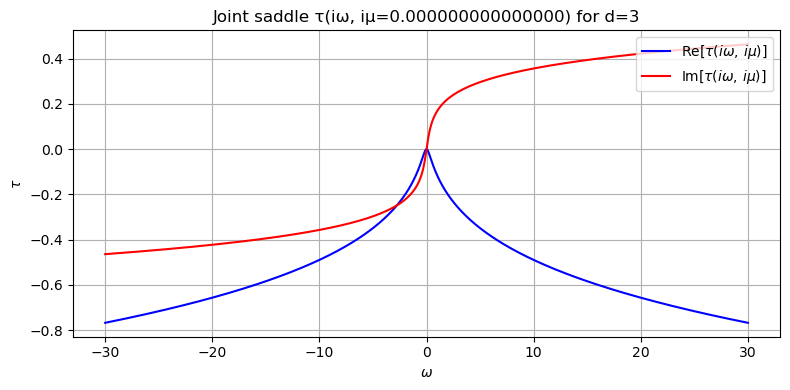

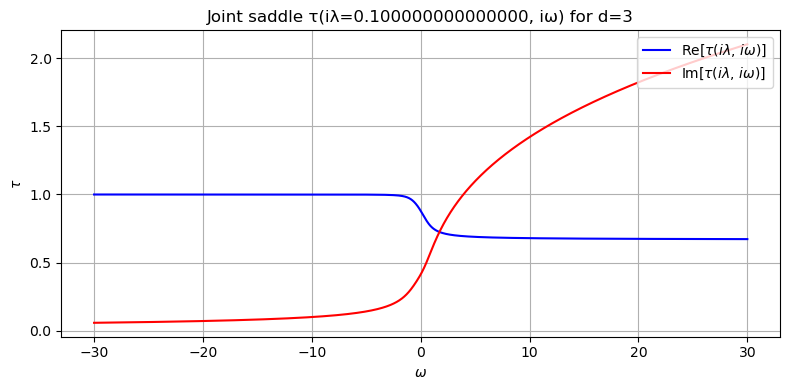

In [75]:
# Hold μ = i·1.0 fixed, vary Λ = iω:
plot_joint_tau_along_imag_Lambda(d=3, mu_imag=0.0, omega_max=30.0, num_points=2000)

# Hold Λ = i·2.0 fixed, vary μ = iω:
plot_joint_tau_along_imag_Mu(d=3, lambda_imag=0.1, omega_max=30.0, num_points=2000)


In [21]:
# === Block J1′: Precompute τ★, A_vals, and φ_{Λμ} on a 2D ω‐grid ===

def precompute_joint_IBP_arrays(d, sigma2, omega_max=60.0, N=200, nu=None):
    """
    Precompute on an N×N grid of ω1,ω2 in [0, omega_max]:
      - τ_vals[j,k]      = τ★ solving ∂_τ S_joint(d; Λ_scaled, μ_scaled; τ) = 0,
      - A_vals[j,k]      = (1/σ²) * S_joint(d; Λ_scaled, μ_scaled; τ★),
      - phi_LM_vals[j,k] = ∂²/∂Λ∂μ [ S_joint(d; Λ, μ; τ★ ) ] 
                           evaluated at Λ=σ² i ω1_j, μ=σ² i ω2_k.

    Returns:
      omegas        : 1D array length N of ω values,
      τ_vals        : shape (N,N) array of complex τ★,
      A_vals        : shape (N,N) array of complex A = S/σ²,
      phi_LM_vals   : shape (N,N) array of complex mixed derivative ∂²S/∂Λ∂μ,
      domega        : float = step size Δω.
    """
    # 1) Build ω grid and Δω
    omegas = np.linspace(0.0, omega_max, N)

    # 2) Declare symbolic variables
    τ = var('tau')      # saddle variable
    Λ = var('Lambda')   # first Laplace var
    μ = var('mu')       # second Laplace var

    # 3) Make the symbolic joint action S_joint(Λ, μ; τ) from your notebook:
    #    (User should already have defined a function action_spherical_joint(d, Λ, μ, nu)
    #     which returns a symbolic expression in terms of tau, Lambda, mu.)
    #    We will differentiate it to build phi_LM_sym.

    # 3a) The symbolic S_joint (unscaled) in τ, Λ, μ:
    S_sym = action_spherical_joint(d, Λ, μ, nu)  # a Sage expression in (tau, Lambda, mu)
    show("S_sym(d={}, Λ, μ):".format(d), S_sym)

    # 3b) Build the mixed second derivative ∂²S_sym/(∂Λ ∂μ):
    phi_LM_sym = diff(diff(S_sym, Λ), μ)  # symbolic ∂²S/∂Λ∂μ
    show("phi_LM_sym(d={}, Λ, μ):".format(d), phi_LM_sym)

    # 4) Allocate result arrays
    τ_vals      = np.zeros((N, N), dtype=complex)
    A_vals      = np.zeros((N, N), dtype=complex)
    phi_LM_vals = np.zeros((N, N), dtype=complex)

    tau_prev = None

    # 5) Loop over ω1, ω2
    for j, ω1 in enumerate(omegas):
        for k, ω2 in enumerate(omegas):
            # 5.1) Build the scaled Laplace variables:
            #    Λ_scaled = σ² * (i ω1),   μ_scaled = σ² * (i ω2)
            Lambda_scaled = CC(0, sigma2 * ω1)   # = i*(σ² ω1)
            Mu_scaled     = CC(0, sigma2 * ω2)   # = i*(σ² ω2)

            # 5.2) Solve for τ★ via the joint saddle equation ∂_τ S_sym(Λ_scaled, μ_scaled) = 0
            τ_star = tau_joint_from_LambdaMu(d, Lambda_scaled, Mu_scaled, tau_prev, nu)
            τ_vals[j, k] = complex(τ_star)
            tau_prev = τ_star

            # 5.3) Evaluate S_sym at (tau=τ_star, Λ=Lambda_scaled, μ=Mu_scaled)
            S_val = complex(S_sym.subs({τ: τ_star, Λ: Lambda_scaled, μ: Mu_scaled}).n())

            # 5.4) Build A_vals[j,k] = S_val / σ²
            A_vals[j, k] = S_val / sigma2

            # 5.5) Evaluate phi_LM_sym (∂²S/∂Λ∂μ) at (τ=τ_star, Λ=Lambda_scaled, μ=Mu_scaled)
            phi_LM_vals[j, k] = complex(
                phi_LM_sym.subs({τ: τ_star, Λ: Lambda_scaled, μ: Mu_scaled}).n()
            )

    return omegas, τ_vals, A_vals, phi_LM_vals


In [22]:
# === Example usage (run once) ===
omegas, τ_vals, A_vals, phi_LM_vals = precompute_joint_IBP_arrays(
     d=3, sigma2=0.5, omega_max=50.0, N=200, nu=None
 )

'S_sym(d=3, Λ, μ):' -9/2*tau^2 - Lambda*(1/(tau - 1)^3 + 1) + 3*(tau^3 - 2*tau^2 + tau)*mu/(tau^3 - 3*tau^2 + 3*tau - 1)

'phi_LM_sym(d=3, Λ, μ):' 0

In [23]:
def P_rho_theta_fast(rho, theta, omegas, A_vals):
    """
    Fast joint PDF P(ρ,θ) using precomputed A_vals over a 2D grid of ω1,ω2.

    A_vals must be a (N×N) array where
      A_vals[j,k] = (1/σ²) · S_joint(d; σ²·(iω1_j), σ²·(iω2_k); τ★)

    and omegas is the 1D array of length N of ω_j values.

    Then
      P(ρ,θ)
      = (1/π²) ∫₀^ωmax ∫₀^ωmax Re[ e^{ A_vals[j,k]  -  i(ω1_j·ρ + ω2_k·θ ) } ]
        dω1 dω2.

    Parameters:
      - rho     : real ρ
      - theta   : real θ
      - omegas  : 1D NumPy array of length N (ω_j points)
      - A_vals  : 2D NumPy array shape (N,N) of complex A_jk
    Returns:
      - float P(ρ,θ) ≈ (1/π²) · double‐trapezoid of Re[…].
    """
    # Build exp( A_jk  - i·(ω1_j·ρ + ω2_k·θ) ) on the 2D grid
    # omegas[:,None] pairs ω1_j with each column, omegas[None,:] pairs ω2_k with each row
    expo = np.exp(
        A_vals
        - 1j * (omegas[:, None] * rho + omegas[None, :] * theta)
    )

    # Take the real part, as the integrand is Re[…]
    real_expo = expo.real

    # First integrate over ω1 (axis=0), leaving an array length N over ω2
    int_ω1 = np.trapezoid(real_expo, omegas, axis=0)

    # Then integrate that result over ω2
    double_integral = np.trapezoid(int_ω1, omegas)

    # Prefactor (1/π²)
    return (1.0 / np.pi**2) * double_integral


In [24]:
# Example usage (after precomputing omegas, A_vals):
rho_vals = np.linspace(0.1, 5.0, 50)
theta_vals = np.linspace(0.1, 5.0, 50)
P_joint = np.zeros((len(rho_vals), len(theta_vals)))
for i, r1 in enumerate(rho_vals):
    for j, r2 in enumerate(theta_vals):
        P_joint[i, j] = P_rho_theta_fast(r1, r2, omegas, A_vals)

NameError: name 'omegas' is not defined

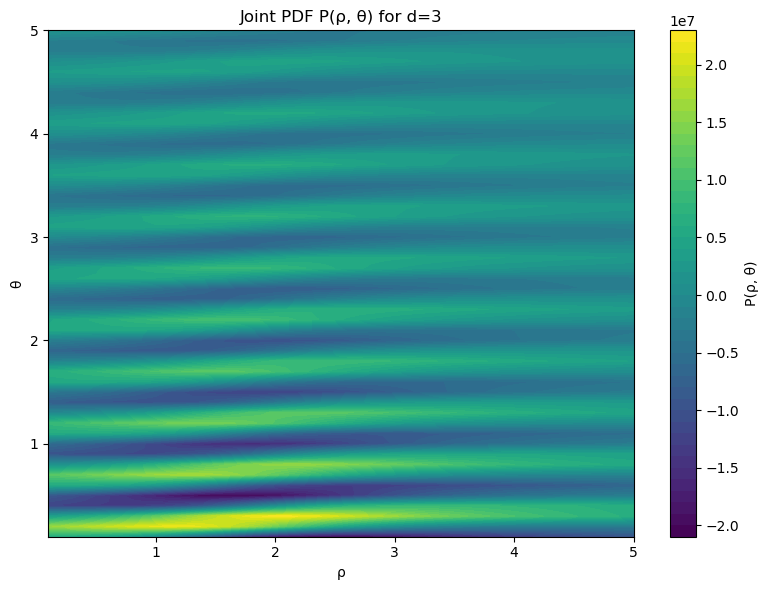

In [66]:
R2, T2 = np.meshgrid(rho_vals, theta_vals)
plt.figure(figsize=(8, 6))
plt.contourf(R2, T2, P_joint, levels=50, cmap='viridis')
plt.colorbar(label='P(ρ, θ)')
plt.title('Joint PDF P(ρ, θ) for d=3')
plt.xlabel('ρ')
plt.ylabel('θ')
plt.tight_layout()
plt.show()

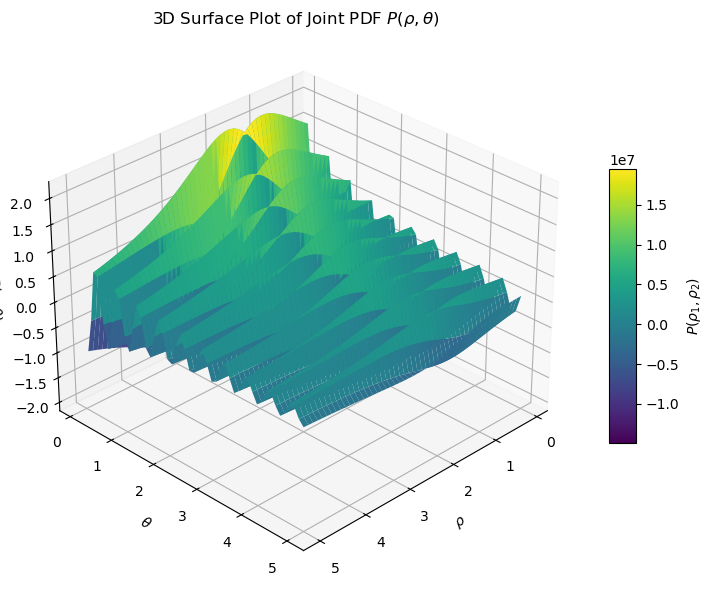

In [67]:
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

# === Assume you have already computed ===
# rho1_vals : 1D array of shape (M,)
# rho2_vals : 1D array of shape (N,)
# P_joint   : 2D array of shape (M, N) containing P(ρ1, ρ2)

# Example (reuse from before):
# rho1_vals = np.linspace(0.1, 5.0, 100)
# rho2_vals = np.linspace(0.1, 5.0, 100)
# P_joint   = np.zeros((len(rho1_vals), len(rho2_vals)))
# for i, r1 in enumerate(rho1_vals):
#     for j, r2 in enumerate(rho2_vals):
#         P_joint[i,j] = P_rho1rho2_fast(r1, r2, omegas, A_vals)

# 2) Begin 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 3) Plot the surface
surf = ax.plot_surface(
    R2,            # X-axis: ρ₂
    T2,            # Y-axis: ρ₁
    P_joint,       # Z-axis: P(ρ₁, ρ₂)
    cmap='viridis',
    linewidth=0,
    antialiased=True
)

# 4) Add a color bar for the surface heights
fig.colorbar(surf, shrink=0.5, aspect=10, label=r"$P(\rho_{1},\rho_{2})$")

# 5) Label axes
ax.set_xlabel(r"$\rho$")
ax.set_ylabel(r"$\theta$")
ax.set_zlabel(r"$P(\rho,\theta)$")

# 6) Title
ax.set_title("3D Surface Plot of Joint PDF $P(\\rho,\\theta)$")

# 7) Adjust view angle if desired (here: elevation=30°, azimuth=45°)
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()


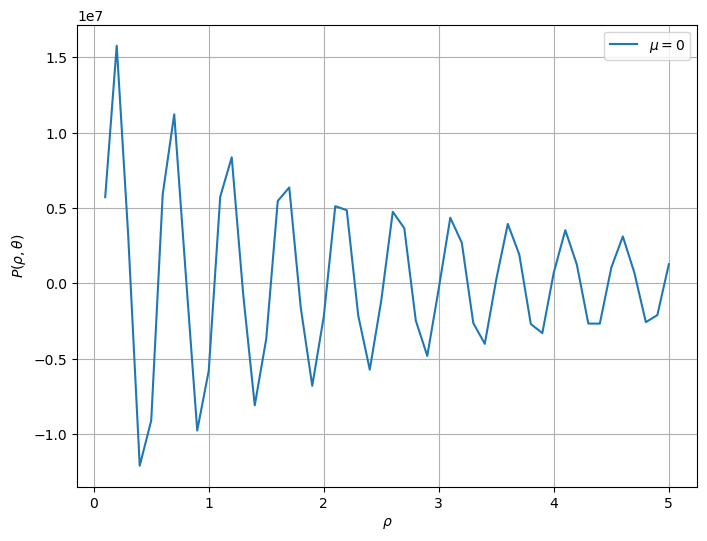

In [68]:
plt.figure(figsize=(8, 6))
plt.plot(rho_vals, P_joint[:, 0], label=r'$\mu=0$')
plt.xlabel(r"$\rho$")
plt.ylabel(r"$P(\rho,\theta)$")
#plt.title("Marginal PDFs $P(\rho,\theta)$")
plt.legend()
plt.grid()
plt.show()


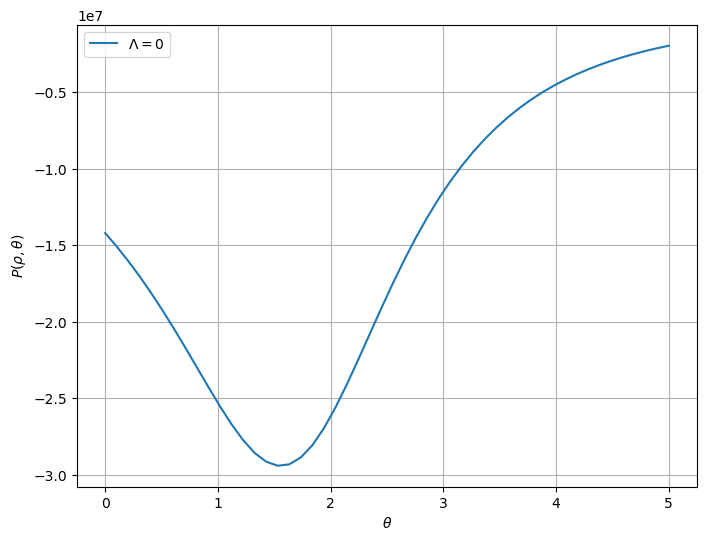

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(rho_vals, P_joint[0, :], label=r'$\Lambda=0$')
plt.xlabel(r"$\theta$")
plt.ylabel(r"$P(\rho,\theta)$")
#plt.title("Marginal PDFs $P(\rho,\theta)$")
plt.legend()
plt.grid()
plt.show()

In [69]:
# === Block J1″′: Precompute τ★, A_vals, and φ_{Λμ} via chain‐rule at the saddle ===

def precompute_joint_IBP_arrays2(d, sigma2, omega_max=60.0, N=200, nu=None):
    """
    On an N×N grid ω1,ω2 ∈ [0, omega_max], precompute:
      - τ_vals[j,k]      = τ★ solving ∂_τ S_joint(d; Λ_scaled, μ_scaled; τ) = 0
      - A_vals[j,k]      = (1/σ²) * S_joint(d; Λ_scaled, μ_scaled; τ★)
      - phi_LM_vals[j,k] = ∂²Φ/(∂Λ ∂μ) at (Λ_scaled, μ_scaled, τ★),
                           computed via chain‐rule:
         φ_{Λμ} = - (S_{τΛ} · S_{τμ}) / S_{ττ}  |_{τ=τ★, Λ=Λ_s, μ=μ_s}

    Here:
      Λ_scaled = σ²·(i ω1_j)
      μ_scaled = σ²·(i ω2_k)

    Returns:
      - omegas       : 1D array of length N of ω values
      - τ_vals       : (N,N) array of τ★ (Python complex)
      - A_vals       : (N,N) array of S/σ² (Python complex)
      - phi_LM_vals  : (N,N) array of ∂²Φ/(∂Λ ∂μ) (Python complex)
      - domega       : float = Δω
    """
    # 1) Build ω grid and Δω
    omegas = np.linspace(0.0, omega_max, N)
    domega = omegas[1] - omegas[0]

    # 2) Symbolic variables
    τ   = var('tau')
    Lam = var('Lambda')
    Mu  = var('mu')

    # 3) User‐provided symbolic action S_joint(τ, Λ, μ)
    S_sym = action_spherical_joint(d, Lam, Mu, nu)

    # 4) Build partial derivatives needed for chain‐rule
    S_tau_sym    = diff(S_sym, τ)               # ∂S/∂τ
    S_tautau_sym = diff(S_tau_sym, τ)            # ∂²S/∂τ²
    S_tauLam_sym = diff(S_tau_sym, Lam)          # ∂²S/(∂τ ∂Λ)
    S_tauMu_sym  = diff(S_tau_sym, Mu)           # ∂²S/(∂τ ∂μ)

    # 5) Allocate arrays
    τ_vals      = np.zeros((N, N), dtype=complex)
    A_vals      = np.zeros((N, N), dtype=complex)
    phi_LM_vals = np.zeros((N, N), dtype=complex)

    tau_prev = None

    # 6) Double loop over ω1, ω2
    for j, ω1 in enumerate(omegas):
        for k, ω2 in enumerate(omegas):
            # 6.1) Build scaled Laplace variables
            Λ_scaled = CC(0, sigma2 * ω1)   # = i*(σ² ω1)
            Mu_scaled = CC(0, sigma2 * ω2)  # = i*(σ² ω2)

            # 6.2) Solve ∂_τ S_sym(Λ_scaled, Mu_scaled) = 0 for τ★
            τ_star = tau_joint_from_LambdaMu(d, Λ_scaled, Mu_scaled, tau_prev, nu)
            τ_vals[j, k] = complex(τ_star)
            tau_prev = τ_star

            # 6.3) Evaluate S_sym at (τ=τ★, Λ=Λ_scaled, μ=Mu_scaled)
            S_val = complex(
                S_sym.subs({τ: τ_star, Lam: Λ_scaled, Mu: Mu_scaled}).n()
            )
            # 6.4) A_vals[j,k] = S_val / σ²
            A_vals[j, k] = S_val / sigma2

            # 6.5) Evaluate S_{τΛ}, S_{τμ}, S_{ττ} at the saddle
            S_tauLam_val  = complex(
                S_tauLam_sym.subs({τ: τ_star, Lam: Λ_scaled, Mu: Mu_scaled}).n()
            )
            S_tauMu_val   = complex(
                S_tauMu_sym.subs({τ: τ_star, Lam: Λ_scaled, Mu: Mu_scaled}).n()
            )
            S_tautau_val  = complex(
                S_tautau_sym.subs({τ: τ_star, Lam: Λ_scaled, Mu: Mu_scaled}).n()
            )

            # 6.6) Compute φ_{Λμ} via the chain‐rule formula:
            #      φ_{Λμ} = - (S_{τΛ} * S_{τμ}) / S_{ττ}
            phi_LM_vals[j, k] = - (S_tauLam_val * S_tauMu_val) / S_tautau_val

    return omegas, τ_vals, A_vals, phi_LM_vals


# === Block J2″′: Fast joint PDF with two IBP steps using precomputed arrays ===

def P_rho_theta_IBP_fast(rho, theta, omegas, A_vals, phi_LM_vals, sigma2):
    """
    Two‐IBP improved joint PDF P(ρ,θ) (with c1=c2=0):

      P(ρ,θ)
      = 1/(π²·ρ·θ)
        ∫₀^ωmax ∫₀^ωmax
          Re[ ( -σ²·φ_{Λμ}[j,k] ) · e^{ A_vals[j,k] - i (ω1_j·ρ + ω2_k·θ) } ]
        dω1 dω2.

    Parameters:
      - rho        : real ρ
      - theta      : real θ
      - omegas     : 1D array length N
      - A_vals     : (N×N) array of φ_tree/σ²
      - phi_LM_vals: (N×N) array of φ_{Λμ} = ∂²Φ/(∂Λ∂μ)
      - domega     : float spacing Δω

    Returns:
      - float P(ρ,θ) ≈ joint PDF at (ρ,θ)
    """
    # 1) Build the 2D exponential e^{ A - i(ω1·ρ + ω2·θ) }
    expo = np.exp(
        A_vals
        - 1j * (omegas[:, None] * rho + omegas[None, :] * theta)
    )

    # 2) Multiply by (-σ² * φ_{Λμ}) and take real part
    integrand = (-sigma2 * phi_LM_vals * expo)

    # 3) Trapezoidal rule: integrate over ω1 (axis=0), then ω2
    int_ω1        = np.trapezoid(integrand, omegas, axis=0)
    double_integral = np.trapezoid(int_ω1, omegas)

    # 4) Prefactor 1/(π² · ρ · θ)
    return (1.0 / (np.pi**2 * rho * theta)) * double_integral.real


In [70]:
# Example usage:
omegas2, τ_vals2, A_vals2, phi_LM_vals2 = precompute_joint_IBP_arrays2(
     d=3, sigma2=0.5, omega_max=50.0, N=50, nu=None
 )

In [71]:
# Example usage (once arrays are precomputed):
P_IBP = np.zeros((len(rho_vals), len(theta_vals)))
for i, r1 in enumerate(rho_vals):
    for j, r2 in enumerate(theta_vals):
        P_IBP[i,j] = P_rho_theta_IBP_fast(
            r1, r2,
            omegas=omegas2,
            A_vals=A_vals2,
            phi_LM_vals=phi_LM_vals2,
            sigma2=0.5
        )

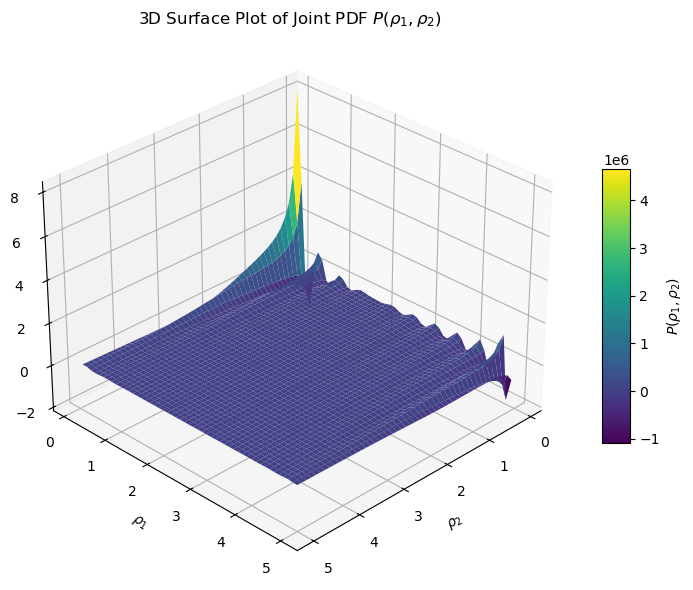

In [72]:
# 2) Begin 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 3) Plot the surface
surf = ax.plot_surface(
    R2,            # X-axis: ρ₂
    T2,            # Y-axis: ρ₁
    P_IBP,         # Z-axis: P(ρ₁, ρ₂)
    cmap='viridis',
    linewidth=0,
    antialiased=True
)

# 4) Add a color bar for the surface heights
fig.colorbar(surf, shrink=0.5, aspect=10, label=r"$P(\rho_{1},\rho_{2})$")

# 5) Label axes
ax.set_xlabel(r"$\rho_{2}$")
ax.set_ylabel(r"$\rho_{1}$")
ax.set_zlabel(r"$P(\rho_{1},\rho_{2})$")

# 6) Title
ax.set_title("3D Surface Plot of Joint PDF $P(\\rho_{1},\\rho_{2})$")

# 7) Adjust view angle if desired
ax.view_init(elev=30, azim=45)

# 8) Set axis limits
#ax.set_xlim(2.0, np.max(R2))
#ax.set_ylim(2.0, np.max(T2))
#ax.set_zlim(np.min(P_IBP), np.max(P_IBP))

plt.tight_layout()
plt.show()


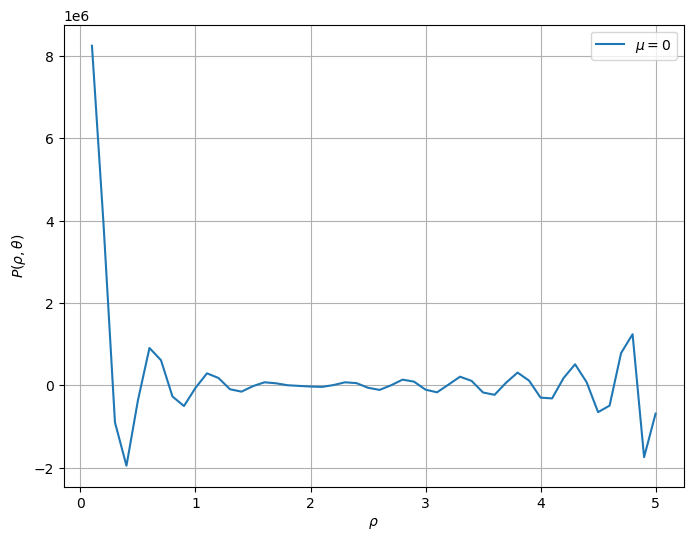

In [73]:
plt.figure(figsize=(8, 6))
plt.plot(rho_vals, P_IBP[:, 0], label=r'$\mu=0$')
plt.xlabel(r"$\rho$")
plt.ylabel(r"$P(\rho,\theta)$")
#plt.title("Marginal PDFs $P(\rho,\theta)$")
plt.legend()
plt.grid()
plt.show()

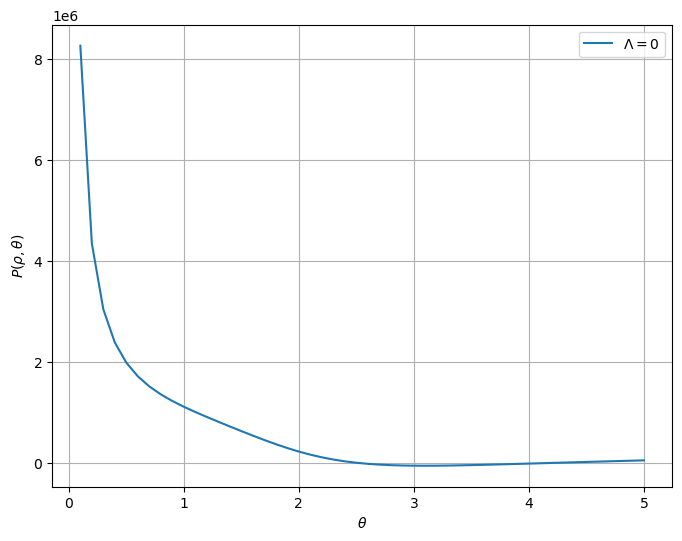

In [74]:
plt.figure(figsize=(8, 6))
plt.plot(rho_vals, P_IBP[0, :], label=r'$\Lambda=0$')
plt.xlabel(r"$\theta$")
plt.ylabel(r"$P(\rho,\theta)$")
#plt.title("Marginal PDFs $P(\rho,\theta)$")
plt.legend()
plt.grid()
plt.show()

In [57]:
# === Block J1′: Precompute τ★, A_vals, and φ_{Λμ} on a 2D ω‐grid ===

def precompute_rho_arrays(d, sigma2, omega_max=40.0, N=200, nu=None):
    """
    Precompute on an N×N grid of ω1,ω2 in [0, omega_max]:
      - τ_vals[j,k]      = τ★ solving ∂_τ S_joint(d; Λ_scaled, μ_scaled; τ) = 0,
      - A_vals[j,k]      = (1/σ²) * S_joint(d; Λ_scaled, μ_scaled; τ★),
      - phi_LM_vals[j,k] = ∂²/∂Λ∂μ [ S_joint(d; Λ, μ; τ★ ) ] 
                           evaluated at Λ=σ² i ω1_j, μ=σ² i ω2_k.

    Returns:
      omegas        : 1D array length N of ω values,
      τ_vals        : shape (N,N) array of complex τ★,
      A_vals        : shape (N,N) array of complex A = S/σ²,
      phi_LM_vals   : shape (N,N) array of complex mixed derivative ∂²S/∂Λ∂μ,
      domega        : float = step size Δω.
    """
    # 1) Build ω grid and Δω
    omegas1 = np.linspace(0.0, omega_max, N)
    omegas2 = [0.0] #np.linspace(0.0, omega_max, N)

    # 2) Declare symbolic variables
    τ = var('tau')      # saddle variable
    Λ = var('Lambda')   # first Laplace var
    μ = var('mu')       # second Laplace var

    # 3) Make the symbolic joint action S_joint(Λ, μ; τ) from your notebook:
    #    (User should already have defined a function action_spherical_joint(d, Λ, μ, nu)
    #     which returns a symbolic expression in terms of tau, Lambda, mu.)
    #    We will differentiate it to build phi_LM_sym.

    # 3a) The symbolic S_joint (unscaled) in τ, Λ, μ:
    S_sym = action_spherical_joint(d, Λ, μ, nu)  # a Sage expression in (tau, Lambda, mu)
    show("S_sym(d={}, Λ, μ):".format(d), S_sym)

    # 4) Allocate result arrays
    τ_vals      = np.zeros(N, dtype=complex)
    A_vals      = np.zeros(N, dtype=complex)

    tau_prev = None

    # 5) Loop over ω1, ω2
    for j, ω1 in enumerate(omegas1):
          # 5.1) Build the scaled Laplace variables:
          #    Λ_scaled = σ² * (i ω1),   μ_scaled = σ² * (i ω2)
          Lambda_scaled = CC(0, sigma2 * ω1)   # = i*(σ² ω1)
          #Mu_scaled     = CC(0, 0) #sigma2 * ω2)   # = i*(σ² ω2)

          # 5.2) Solve for τ★ via the joint saddle equation ∂_τ S_sym(Λ_scaled, μ_scaled) = 0
          τ_star = tau_joint_from_LambdaMu(d, Lambda_scaled, 0.0, tau_prev, nu)
          τ_vals[j] = complex(τ_star)
          tau_prev = τ_star

          # 5.3) Evaluate S_sym at (tau=τ_star, Λ=Lambda_scaled, μ=Mu_scaled)
          S_val = complex(S_sym.subs({τ: τ_star, Λ: Lambda_scaled, μ: 0.0}).n()) + Lambda_scaled
  
            # 5.4) Build A_vals[j] = S_val / σ²
          A_vals[j] = S_val / sigma2

    return omegas1, τ_vals, A_vals


In [58]:
omegas_rho, τ_vals_rho, A_vals_rho = precompute_rho_arrays(
     d=3, sigma2=1.0, omega_max=40.0, N=200, nu=None
 )

'S_sym(d=3, Λ, μ):' -9/2*tau^2 - Lambda*(1/(tau - 1)^3 + 1) + 3*(tau^3 - 2*tau^2 + tau)*mu/(tau^3 - 3*tau^2 + 3*tau - 1)

In [59]:
show("A_vals =", A_vals_rho[0:10])

'A_vals =' array([ 0.        +0.j        , -0.01851112+0.19633109j,
       -0.06220453+0.37393465j, -0.1168651 +0.53211493j,
       -0.17592756+0.67484099j, -0.23657578+0.80548509j,
       -0.29750818+0.9264848j , -0.35808439+1.03959812j,
       -0.41797954+1.14612345j, -0.4770303 +1.24704564j])

In [60]:
def P_rho_fast(rho, omegas, A_vals):
    expo = np.exp(A_vals - 1j * omegas * rho)
    integrand =  expo
    integral = np.trapezoid(integrand, omegas)
    return (1.0 / np.pi) * integral.real

In [64]:
# Example usage (after precomputing omegas, A_vals):
rho_vals = np.linspace(0.01, 10.0, 1000)
#theta_vals = np.linspace(0.1, 5.0, 50)
P_rho = np.zeros(len(rho_vals))
for i, r1 in enumerate(rho_vals):
    P_rho[i] = P_rho_fast(r1, omegas_rho, A_vals_rho)

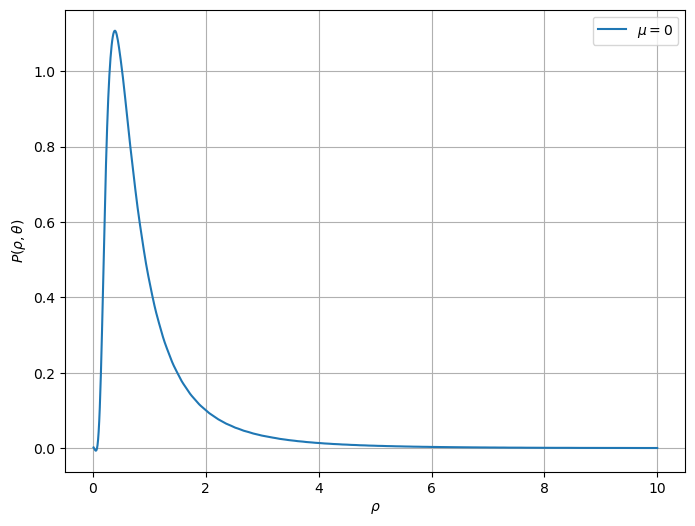

In [65]:
plt.figure(figsize=(8, 6))
plt.plot(rho_vals, P_rho, label=r'$\mu=0$')
plt.xlabel(r"$\rho$")
plt.ylabel(r"$P(\rho,\theta)$")
#plt.title("Marginal PDFs $P(\rho,\theta)$")
plt.legend()
plt.grid()
plt.show()


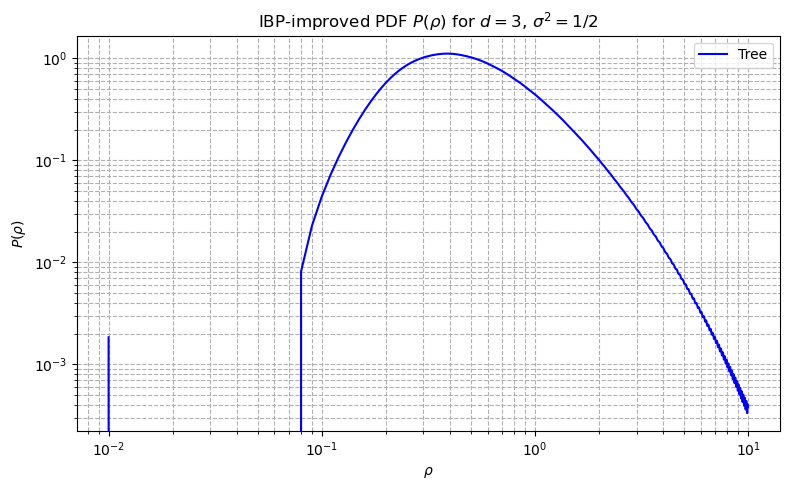

In [66]:
plt.figure(figsize=(8,5))
plt.loglog(rho_vals, P_rho,    '-b', label='Tree')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$P(\rho)$')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.title(r"IBP‐improved PDF $P(\rho)$ for $d=3$, $\sigma^2=1/2$")
plt.tight_layout()
plt.show()

In [68]:
# === Block J1′: Precompute τ★, A_vals, and φ_{Λμ} on a 2D ω‐grid ===

def precompute_theta_arrays(d, sigma2, omega_max=40.0, N=200, nu=None):
    """
    Precompute on an N×N grid of ω1,ω2 in [0, omega_max]:
      - τ_vals[j,k]      = τ★ solving ∂_τ S_joint(d; Λ_scaled, μ_scaled; τ) = 0,
      - A_vals[j,k]      = (1/σ²) * S_joint(d; Λ_scaled, μ_scaled; τ★),
      - phi_LM_vals[j,k] = ∂²/∂Λ∂μ [ S_joint(d; Λ, μ; τ★ ) ] 
                           evaluated at Λ=σ² i ω1_j, μ=σ² i ω2_k.

    Returns:
      omegas        : 1D array length N of ω values,
      τ_vals        : shape (N,N) array of complex τ★,
      A_vals        : shape (N,N) array of complex A = S/σ²,
      phi_LM_vals   : shape (N,N) array of complex mixed derivative ∂²S/∂Λ∂μ,
      domega        : float = step size Δω.
    """
    # 1) Build ω grid and Δω
    omegas1 = [0.0] #np.linspace(0.0, omega_max, N)
    omegas2 = np.linspace(0.0, omega_max, N)

    # 2) Declare symbolic variables
    τ = var('tau')      # saddle variable
    Λ = var('Lambda')   # first Laplace var
    μ = var('mu')       # second Laplace var

    # 3) Make the symbolic joint action S_joint(Λ, μ; τ) from your notebook:
    #    (User should already have defined a function action_spherical_joint(d, Λ, μ, nu)
    #     which returns a symbolic expression in terms of tau, Lambda, mu.)
    #    We will differentiate it to build phi_LM_sym.

    # 3a) The symbolic S_joint (unscaled) in τ, Λ, μ:
    S_sym = action_spherical_joint(d, Λ, μ, nu)  # a Sage expression in (tau, Lambda, mu)
    show("S_sym(d={}, Λ, μ):".format(d), S_sym)

    # 4) Allocate result arrays
    τ_vals      = np.zeros(N, dtype=complex)
    A_vals      = np.zeros(N, dtype=complex)

    tau_prev = None

    # 5) Loop over ω1, ω2
    for j, ω2 in enumerate(omegas2):
          # 5.1) Build the scaled Laplace variables:
          #    Λ_scaled = σ² * (i ω1),   μ_scaled = σ² * (i ω2)
          #Lambda_scaled = CC(0, sigma2 * ω1)   # = i*(σ² ω1)
          Mu_scaled     = CC(0, sigma2 * ω2)   # = i*(σ² ω2)

          # 5.2) Solve for τ★ via the joint saddle equation ∂_τ S_sym(Λ_scaled, μ_scaled) = 0
          τ_star = tau_joint_from_LambdaMu(d, 0.0, Mu_scaled, tau_prev, nu)
          τ_vals[j] = complex(τ_star)
          tau_prev = τ_star

          # 5.3) Evaluate S_sym at (tau=τ_star, Λ=Lambda_scaled, μ=Mu_scaled)
          S_val = complex(S_sym.subs({τ: τ_star, Λ: 0.0, μ: Mu_scaled}).n())

          # 5.4) Build A_vals[j] = S_val / σ²
          A_vals[j] = S_val / sigma2

    return omegas2, τ_vals, A_vals


In [93]:
omegas_theta, τ_vals_theta, A_vals_theta = precompute_theta_arrays(
     d=3, sigma2=1.0, omega_max=100.0, N=200, nu=None
 )

'S_sym(d=3, Λ, μ):' -9/2*tau^2 - Lambda*(1/(tau - 1)^3 + 1) + 3*(tau^3 - 2*tau^2 + tau)*mu/(tau^3 - 3*tau^2 + 3*tau - 1)

In [94]:
def P_theta_fast(theta, omegas, A_vals):
    expo = np.exp(A_vals - 1j * omegas * theta)
    integrand =  expo
    integral = np.trapezoid(integrand, omegas)
    return (1.0 / np.pi) * integral.real

In [95]:
theta_vals = np.linspace(-10.0, 10.0, 1000)
P_theta = np.zeros(len(theta_vals))
for i, t1 in enumerate(theta_vals):
    P_theta[i] = P_theta_fast(t1, omegas_theta, A_vals_theta)

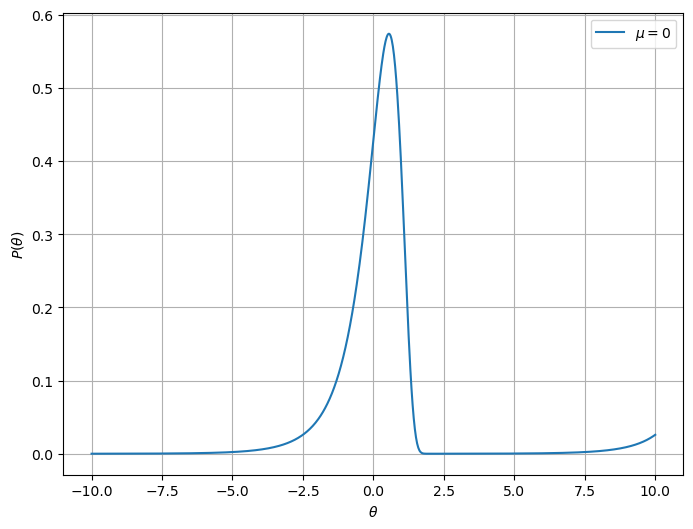

In [96]:
plt.figure(figsize=(8, 6))
plt.plot(theta_vals, P_theta, label=r'$\mu=0$')
plt.xlabel(r"$\theta$")
plt.ylabel(r"$P(\theta)$")
#plt.title("Marginal PDFs $P(\rho,\theta)$")
plt.legend()
plt.grid()
plt.show()


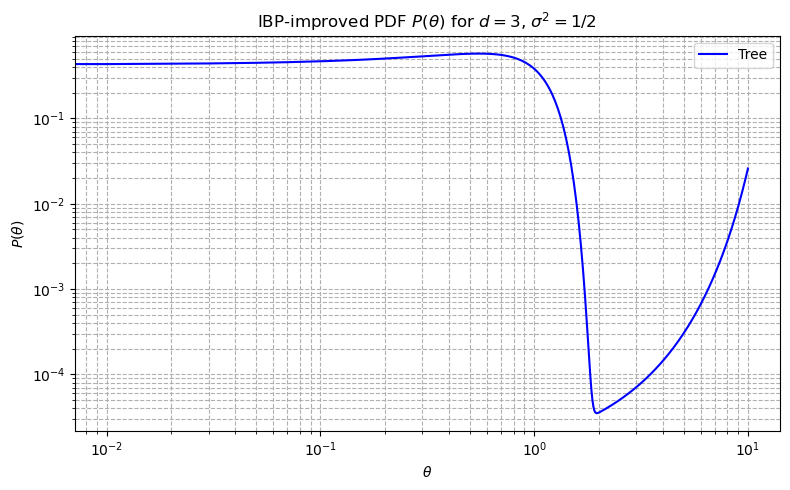

In [97]:
plt.figure(figsize=(8,5))
plt.loglog(theta_vals, P_theta,    '-b', label='Tree')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$P(\theta)$')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.title(r"IBP‐improved PDF $P(\theta)$ for $d=3$, $\sigma^2=1/2$")
plt.tight_layout()
plt.show()